In [1]:

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

current_dir = os.getcwd()
information_metrics_dir = os.path.dirname(current_dir)
sys.path.append(information_metrics_dir)

import src.utils.helper_functions as helper
import src.utils.bootstrapped_estimation as be
import src.utils.normalizing_functions as norm

from src.data.data_loader import LoadData
from src.data.data_processing import ProcessData
from src.utils import pre_processing_functions as pre_process
import src.data.cell_model_base as cs_model

%matplotlib widget


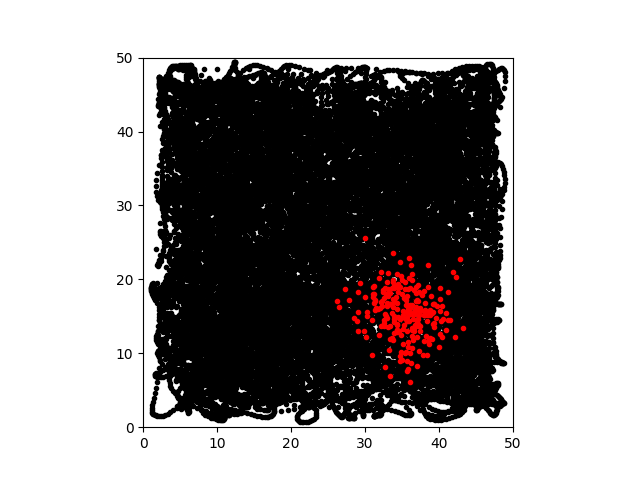

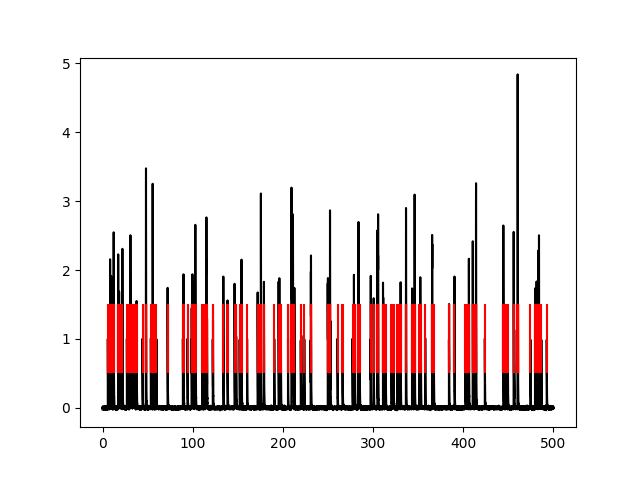

In [2]:
# Cell simulation parameters
sampling_rate = 50. # points/frames per second
duration = 500 # in seconds
rate = 20 # how much your neuron should spike
environment_edges = [[0,50],[0,50]] # in cm [[x_min,x_max],[y_min,y_max]]
smooth_time = 0.1
rho1 = 0.02
sigma = 1
mu_e = 0.

# Define field parameters
num_of_fields = 1
field1_center = (35, 15)
field1_size = 3

# field1_center = (5, 15)
# field2_center = (20, 7)
# field3_center = (35, 25)
# field1_size = 2
# field2_size = 1
# field3_size = 4

x_coordinates,y_coordinates,speed,speed_smoothed,time_vector = cs_model.generate_random_walk(input_srate = sampling_rate,input_total_Time = duration,heading_srate = 10., speed_srate = 5., rho1  = rho1,sigma = sigma,mu_e  = mu_e, smooth_points = int(np.round(smooth_time*sampling_rate)),environment_edges = environment_edges)
total_points = time_vector.shape[0]

spike_times = cs_model.generate_poisson_spikes(rate, duration)
spike_times_idx = (spike_times*sampling_rate).astype(int)

if num_of_fields == 0:
    modulated_spike_times_idx = spike_times_idx.copy()
else:
    modulated_spike_times_idx = []
    for counter in range(num_of_fields):
        field_center = eval('field' + str(counter+1) + '_center')
        field_size = eval('field' + str(counter+1) + '_size')
        modulated_spike_times_idx_aux = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,spike_times_idx,x_center = field_center[0],y_center = field_center[1], s = field_size)
    
        modulated_spike_times_idx.append(modulated_spike_times_idx_aux)
    modulated_spike_times_idx = np.unique(np.concatenate(modulated_spike_times_idx)).astype(int)
    
signal,time_vector = cs_model.generate_calcium_signal(modulated_spike_times_idx,total_points,sampling_rate,noise_level = 0.01, b = 5.)
peaks_idx = helper.detect_peaks(signal,mpd=0.5*sampling_rate,mph=1.*np.nanstd(signal))


plt.close('all')
plt.figure()
plt.plot(x_coordinates, y_coordinates,'k.')
if len(modulated_spike_times_idx) > 0:
    plt.plot(x_coordinates[modulated_spike_times_idx],y_coordinates[modulated_spike_times_idx],color = 'red',linestyle='',marker='.',markersize=6)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.gca().set_aspect('equal', 'box')
plt.show()

plt.figure()
plt.plot(time_vector, signal,'k')
if len(modulated_spike_times_idx) > 0:
    plt.eventplot(time_vector[modulated_spike_times_idx],color='red')
plt.show()

signal_type = 'filtered'
signal_data = ProcessData(signal, x_coordinates, y_coordinates, time_vector, sampling_rate, environment_edges)
